In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "/Users/sebastianjaszczur/PycharmProjects/deepsat/attention_cmp/1552640099"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from /Users/sebastianjaszczur/PycharmProjects/deepsat/attention_cmp/1552640099/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
from time import time

In [4]:
import sys 
sys.path.insert(0,'../..')

In [5]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL, JeroslowWangDPLL
from cdcl import CDCL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR, get_sat_SR
from tqdm import tqdm
from collections import Counter

In [6]:
LIMIT_RUNS = 1000

In [7]:
CDCL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))

[1, -2]

In [8]:
JeroslowWangDPLL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))

[-2, 1]

In [9]:
cnf = get_pos_SR(15, 15, 2000)
print("Generated")
# print(cnf)
start = time()
CDCL().run(cnf)
end = time()
print(end-start)
start = time()
DPLL().run(cnf)
end = time()
print(end-start)

Generated
0.050195932388305664
0.05519700050354004


In [10]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)

In [11]:
jw([[-1, -2], [+1, -2]])

-2

In [12]:
np.set_printoptions(precision=3, suppress=True)

In [13]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [14]:
class GraphBasedCDCL(CDCL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        #print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

class JeroslawCDCL(CDCL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [15]:
def compute_steps(sats, cdcl_cls):
    steps = []
    solved = 0
    for sat in sats:
        cdcl = cdcl_cls()
        res = cdcl.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(cdcl.number_of_runs)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps

In [20]:
def compute_and_print_steps(sats, dpll_cls):
    print("")
    print("Results of {}".format(dpll_cls.__name__))
    steps = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps)))
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    """
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()
    """

In [17]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    compute_and_print_steps(sats, GraphBasedCDCL)
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    # compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    
    
    compute_and_print_steps(sats, JeroslawCDCL)
    #logfile.flush()

In [18]:
#print_all(10, 200, 50)

We have generated 30 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 10.70; stdev step: 7.01

Results of JeroslawCDCL
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 10.63; stdev step: 5.06


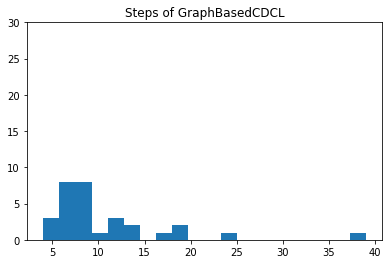

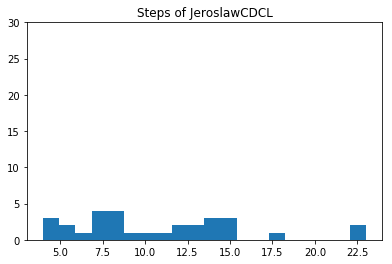

In [21]:
print_all(30, 200, 20)

We have generated 10 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 9.20; stdev step: 4.77

Results of JeroslawCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.50; stdev step: 5.39


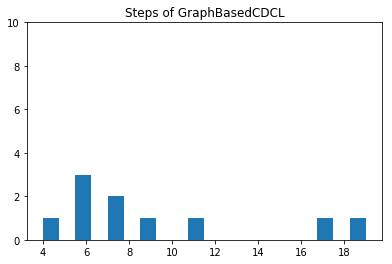

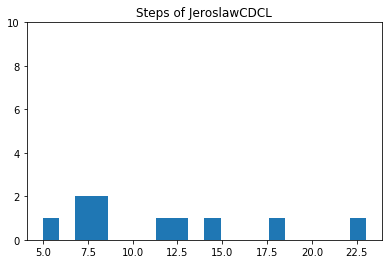

In [22]:
print_all(10, 200, 20)

We have generated 100 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 4.55; stdev step: 1.50

Results of JeroslawCDCL
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.01; stdev step: 1.82


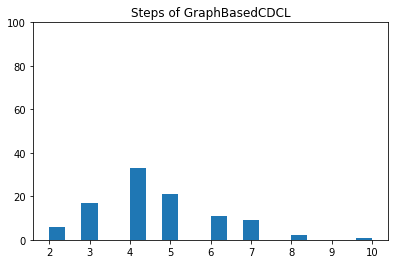

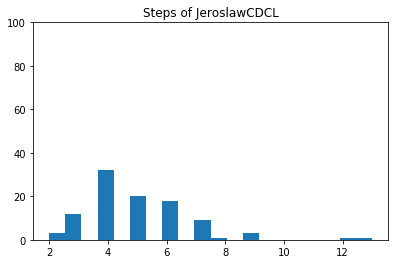

In [23]:
print_all(100, 200, 10)

We have generated 10 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 12.20; stdev step: 5.15

Results of JeroslawCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 12.50; stdev step: 7.12


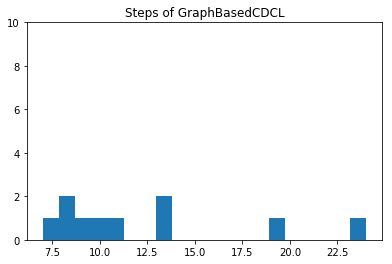

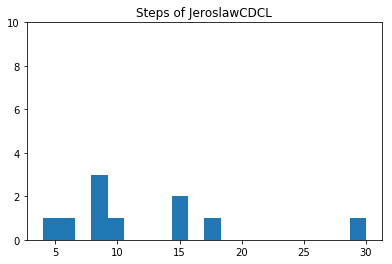

In [24]:
print_all(10, 500, 25, light=True)

We have generated 10 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 12.90; stdev step: 9.49

Results of JeroslawCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 19.10; stdev step: 11.06


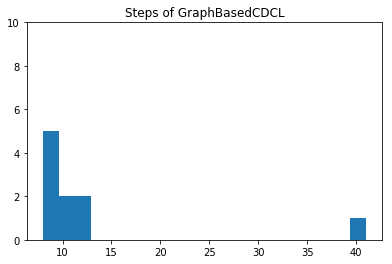

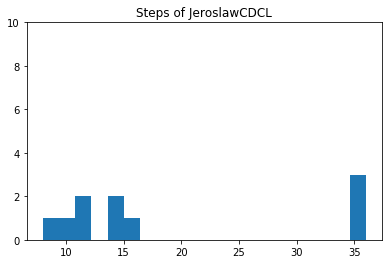

In [25]:
print_all(10, 500, 30, light=True)

We have generated 10 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 25.80; stdev step: 35.47

Results of JeroslawCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 42.00; stdev step: 20.39


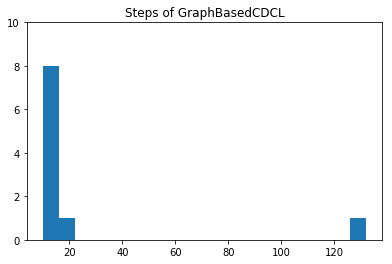

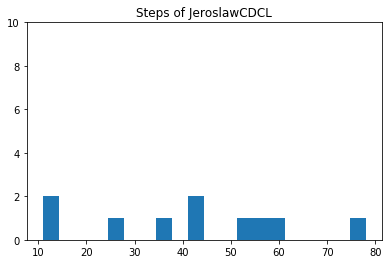

In [26]:
print_all(10, 1000, 40, light=True)

We have generated 10 formulas

Results of GraphBasedCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 64.90; stdev step: 99.87

Results of JeroslawCDCL
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 57.50; stdev step: 39.37


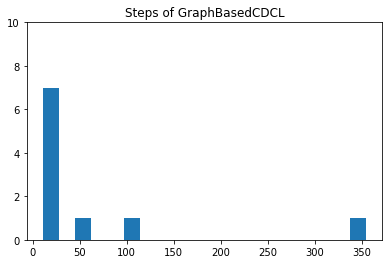

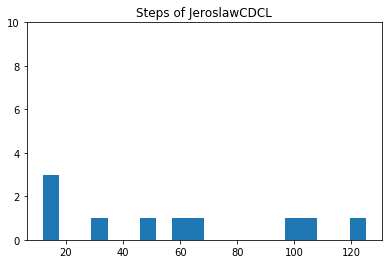

In [27]:
print_all(10, 1000, 50, light=True)

In [28]:
print_all(10, 1000, 70, light=True)

We have generated 10 formulas

Results of GraphBasedCDCL


KeyboardInterrupt: 

In [29]:
print_all(10, 1000, 90, light=True)

We have generated 10 formulas


KeyboardInterrupt: 